## Workspace setup

In [1]:
from datetime import datetime  
import uproot
from functools import partial
import numpy as np
import tensorflow as tf
import importlib

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

2023-11-21 15:49:08.305914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training dataset preparation

In [2]:
import io_functions as io
importlib.reload(io)

import plotting_functions as plf
importlib.reload(plf)

batchSize = 20
#fileBatchSize = 200

#dataPath = '/scratch_hdd/akalinow/ELITPC/data/PythonAnalysis/E_11_sigma_1.5/'
#train_files = [dataPath+'out_{1,2,3}.root:TPCData']

#dataPath = '/scratch_hdd/akalinow/ELITPC/data/PythonAnalysis/E_11_sigma_flat_1_2/'
dataPath = '/scratch/szslaw/'
"""
train_files = [dataPath+'out_random_sigma-001.root:TPCData']
            
datasetGenerator = partial(io.generator, files=train_files, batchSize=batchSize)
train_dataset = tf.data.Dataset.from_generator(
     datasetGenerator,
     output_signature=(
         tf.TensorSpec(shape=(batchSize,) + (io.projections.shape), dtype=tf.float32),
         tf.TensorSpec(shape=(batchSize,9), dtype=tf.float32)))

for aBatch in train_dataset.take(1):
    plf.plotEvent(aBatch, model=None)
    pass

#dataPath = '/scratch_hdd/akalinow/ELITPC/data/PythonAnalysis/E_11_sigma_1.5/'
dataPath = '/scratch/szslaw/'
#test_files = [dataPath+'out_4.root:TPCData']
test_files = [dataPath+'out_random_sigma2k2mm.root:TPCData']

datasetGenerator = partial(io.generator, files=test_files, batchSize=batchSize)

test_dataset = tf.data.Dataset.from_generator(
     datasetGenerator,
     output_signature=(
         tf.TensorSpec(shape=(batchSize,) + (io.projections.shape), dtype=tf.float32),
         tf.TensorSpec(shape=(batchSize,9), dtype=tf.float32)))
 
for aBatch in test_dataset.take(1):
    plf.plotEvent(aBatch, model=None)
    pass
"""

"\ntrain_files = [dataPath+'out_random_sigma-001.root:TPCData']\n            \ndatasetGenerator = partial(io.generator, files=train_files, batchSize=batchSize)\ntrain_dataset = tf.data.Dataset.from_generator(\n     datasetGenerator,\n     output_signature=(\n         tf.TensorSpec(shape=(batchSize,) + (io.projections.shape), dtype=tf.float32),\n         tf.TensorSpec(shape=(batchSize,9), dtype=tf.float32)))\n\nfor aBatch in train_dataset.take(1):\n    plf.plotEvent(aBatch, model=None)\n    pass\n\n#dataPath = '/scratch_hdd/akalinow/ELITPC/data/PythonAnalysis/E_11_sigma_1.5/'\ndataPath = '/scratch/szslaw/'\n#test_files = [dataPath+'out_4.root:TPCData']\ntest_files = [dataPath+'out_random_sigma2k2mm.root:TPCData']\n\ndatasetGenerator = partial(io.generator, files=test_files, batchSize=batchSize)\n\ntest_dataset = tf.data.Dataset.from_generator(\n     datasetGenerator,\n     output_signature=(\n         tf.TensorSpec(shape=(batchSize,) + (io.projections.shape), dtype=tf.float32),\n       

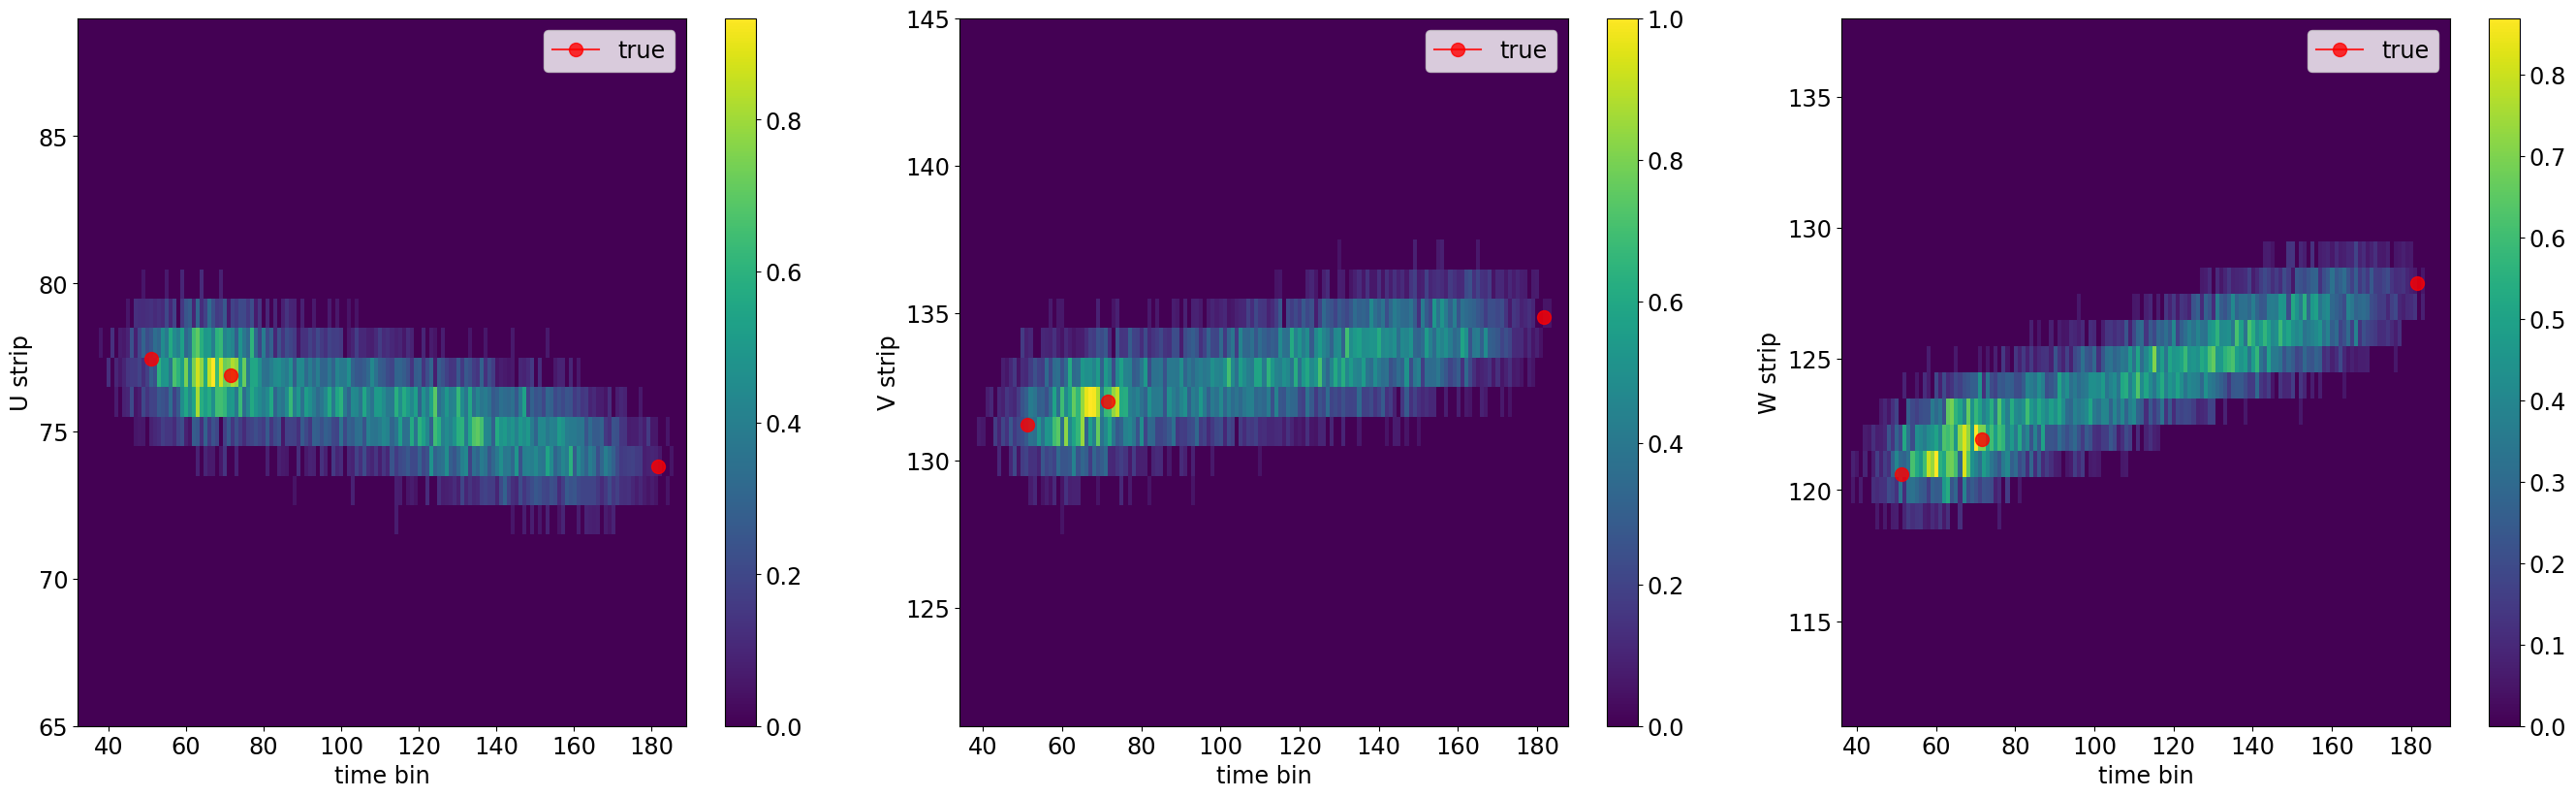

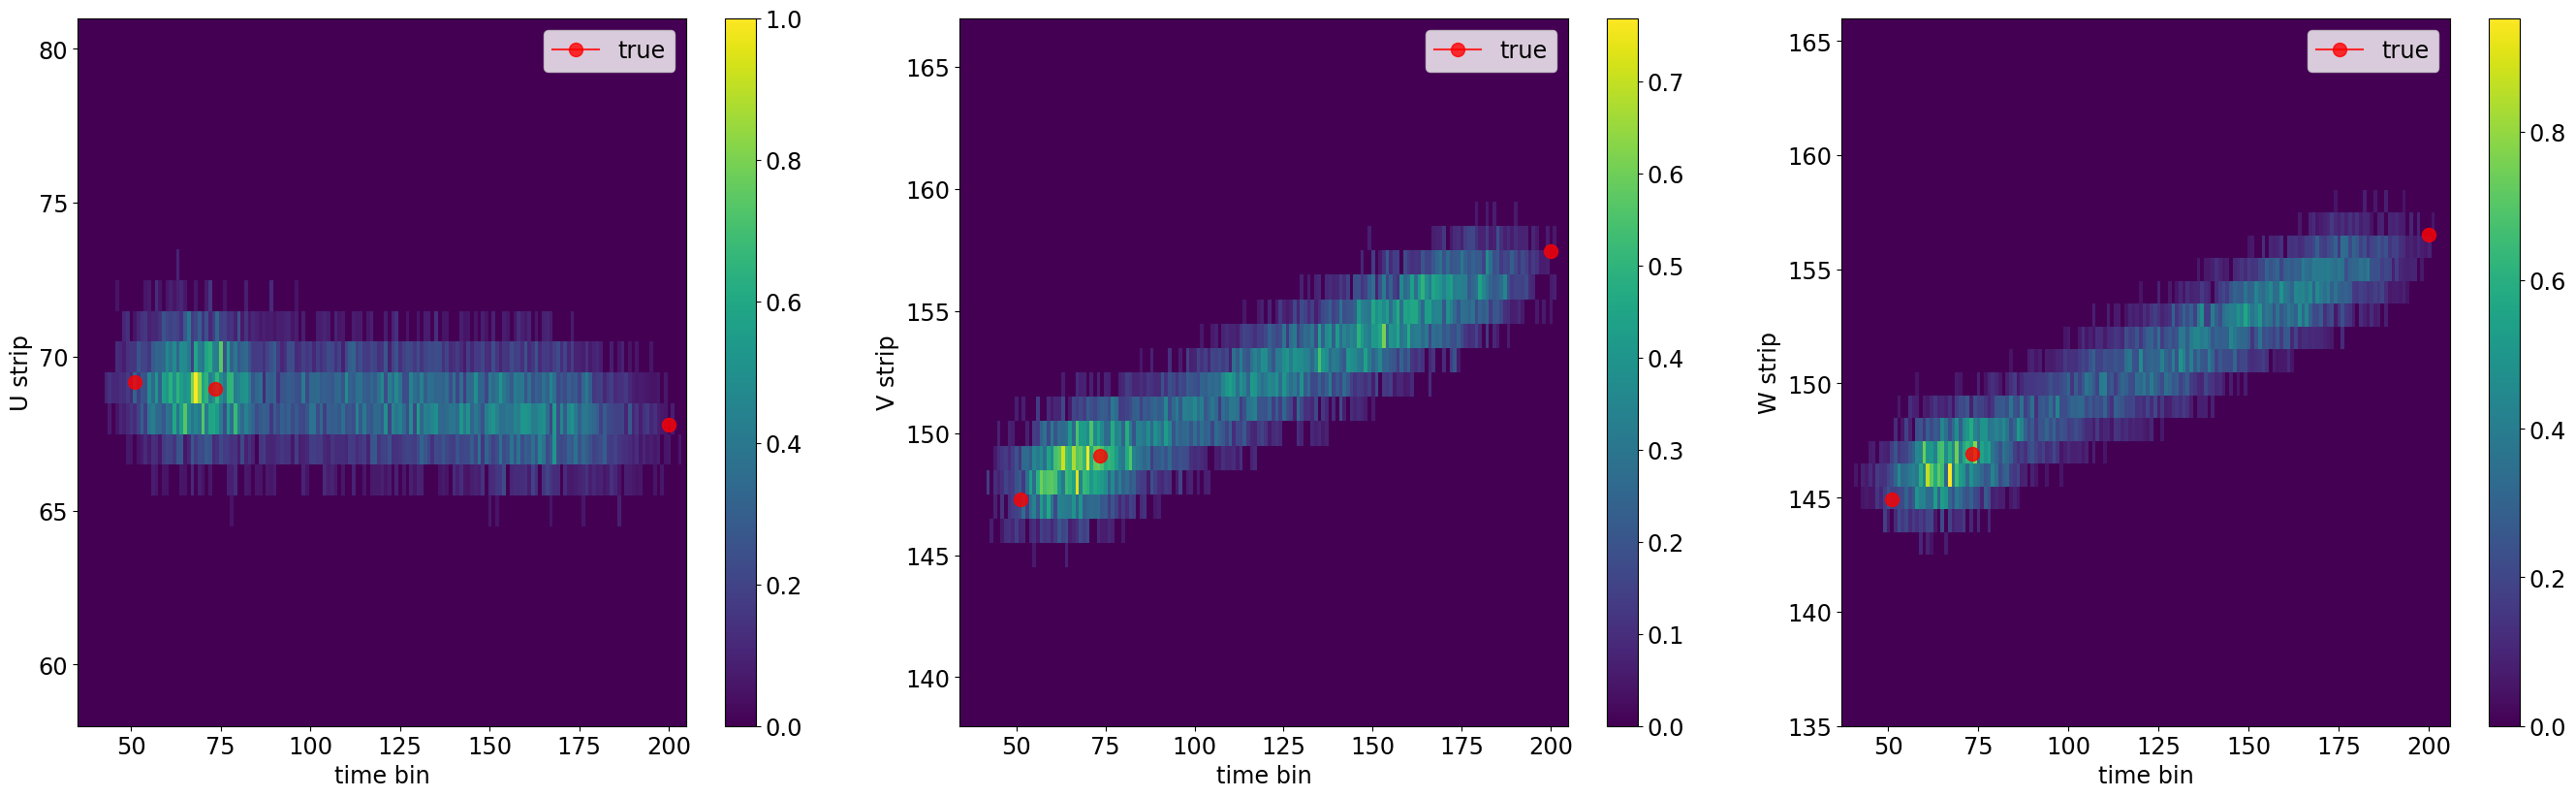

In [6]:
filenames = [dataPath +"folder/"+ f"out_random_sigma-001-part-{i}.tfrecord" for i in range(5)]
train_dataset = tf.data.TFRecordDataset(filenames, compression_type='GZIP', num_parallel_reads=5)
test_dataset = tf.data.TFRecordDataset(dataPath +"folder/"+'out_random_sigma2k2mm.tfrecord', compression_type='GZIP')
# Create a description of the features.
feature_description = {
    'myChargeArray': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.string),

}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    charge, target = parsed_features['myChargeArray'], parsed_features['target']
    # decode from bytes
    charge = tf.io.parse_tensor(charge, tf.float64)
    target = tf.io.parse_tensor(target, tf.float64)
    
    return charge, target

def shape_items(charge, target):
    charge.set_shape(charge_shape)
    target.set_shape(target_shape)
    return charge, target

train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.unbatch()
test_dataset = test_dataset.unbatch()

train_dataset = train_dataset.batch(batchSize)
test_dataset = test_dataset.batch(batchSize)

for charge, target in train_dataset.take(1):
    charge_shape = charge.shape
    target_shape = target.shape

    train_dataset = train_dataset.map(shape_items)
    test_dataset = test_dataset.map(shape_items)

#train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
#test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

for aBatch in train_dataset.take(1):
    plf.plotEvent(aBatch, model=None)
    pass

for aBatch in test_dataset.take(1):
    plf.plotEvent(aBatch, model=None)
    pass

## Model definition

In [4]:
model = tf.keras.Sequential([
  tf.keras.layers.Resizing(height=128, width=128), 
  #tf.keras.layers.GaussianNoise(stddev=0.1),
  tf.keras.layers.Conv2D(16, 5, padding='same', activation='relu', 
                         data_format="channels_last"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 5, padding='same', activation='relu', 
                         data_format="channels_last"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 5, padding='same', activation='relu', 
                         data_format="channels_last"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'), 
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(9)
])

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=5000,
                decay_rate=0.98,
                staircase=False)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule) 
model.compile(optimizer = optimizer, 
              loss = 'mse', 
              metrics=['mse']) 

## Model training

In [5]:
%%time

import plotting_functions as plf
importlib.reload(plf)

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=(10, 20))
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)
callbacks =  [tensorboard_callback, early_stop_callback]

epochs=5

history = model.fit(train_dataset, 
                    epochs=epochs,
                    #verbose = 0,
                    workers = 3,
                    use_multiprocessing = True,
                    validation_data = test_dataset.take(10),
                    callbacks=callbacks
                    )
plf.plotTrainHistory(history)

current_time = datetime.now().strftime("%Y_%b_%d_%H_%M_%S")
print("Training start. Current Time =", current_time)

job_dir = "training/{epochs:04d}_"+current_time
model.save(job_dir.format(epochs=epochs), save_format='tf')

model.summary()
tf.keras.utils.plot_model(
    model, to_file="fig_png/model.png",
    show_shapes=True, show_dtype=False, show_layer_names=True,
    rankdir="TB", expand_nested=False,
    dpi=96, layer_range=None,
    show_layer_activations=True, show_trainable=False)

Epoch 1/5


2023-11-21 15:49:25.668098: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-11-21 15:49:25.668155: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-11-21 15:49:25.671929: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


      9/Unknown - 6s 428ms/step - loss: 0.1786 - mse: 0.1786

2023-11-21 15:49:31.329661: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-11-21 15:49:31.329730: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


     20/Unknown - 10s 431ms/step - loss: 0.1274 - mse: 0.1274

2023-11-21 15:49:36.080152: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-11-21 15:49:36.098620: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-11-21 15:49:36.099833: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: logs/fit/20231121-154925/plugins/profile/2023_11_21_15_49_36/zcobl3.xplane.pb


    168/Unknown - 72s 420ms/step - loss: 0.0557 - mse: 0.0557

KeyboardInterrupt: 

## Model performance on training data.

Fill Pandas DataFrame with true and response values.

Inference. Current Time = 2023_Jun_02_08_36_38


2023-06-02 08:39:17.989115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


CPU times: user 2min 23s, sys: 35.2 s, total: 2min 58s
Wall time: 2min 47s


,GEN_StartPosX,GEN_StartPosY,GEN_StartPosZ,GEN_StopPosX_Part1,GEN_StopPosY_Part1,GEN_StopPosZ_Part1,GEN_StopPosX_Part2,GEN_StopPosY_Part2,GEN_StopPosZ_Part2,RECO_StartPosX,RECO_StartPosY,RECO_StartPosZ,RECO_StopPosX_Part1,RECO_StopPosY_Part1,RECO_StopPosZ_Part1,RECO_StopPosX_Part2,RECO_StopPosY_Part2,RECO_StopPosZ_Part2
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.210221,-0.025195,-38.550678,-1.305794,-0.087202,-38.528667,-0.238072,-0.019177,-38.551361,-1.712808,0.839341,-37.646717,0.269067,0.261961,-35.921795,-2.315103,0.823224,-37.755260
std,57.736366,9.975066,18.800367,69.971413,35.392815,23.081352,57.873447,10.857377,22.143818,56.858566,9.580867,18.396984,72.901123,34.814163,24.128498,56.831013,10.321741,21.677454
min,-99.994888,-19.975468,-52.946007,-230.171753,-180.271393,-160.544693,-110.854744,-29.131535,-52.946163,-103.617928,-22.851362,-58.606583,-245.332581,-132.774429,-84.662766,-113.500870,-28.862629,-60.807972
25%,-50.212770,-8.154796,-50.189458,-53.590239,-20.900330,-52.946163,-50.663444,-8.268098,-52.946163,-52.804436,-7.005432,-49.407526,-54.874829,-20.321630,-52.417801,-53.333405,-7.174268,-52.402447
50%,0.746146,-0.121709,-46.970955,-1.062624,0.065782,-52.946163,0.377222,-0.056747,-52.856037,-1.395761,1.134702,-46.315588,0.569645,0.872315,-48.241133,-2.096842,1.114167,-50.237120
75%,49.575257,8.052902,-33.850958,52.026340,20.769297,-30.102287,49.610434,8.147885,-30.426075,47.816933,8.734693,-31.616324,56.037970,21.117542,-25.362769,47.386349,8.765810,-28.514246
max,99.995995,19.987448,64.027122,255.200409,175.366196,153.839554,109.796524,29.723600,74.082649,102.832268,25.502348,65.214920,219.220154,126.183716,125.810028,109.607292,30.267658,74.359879


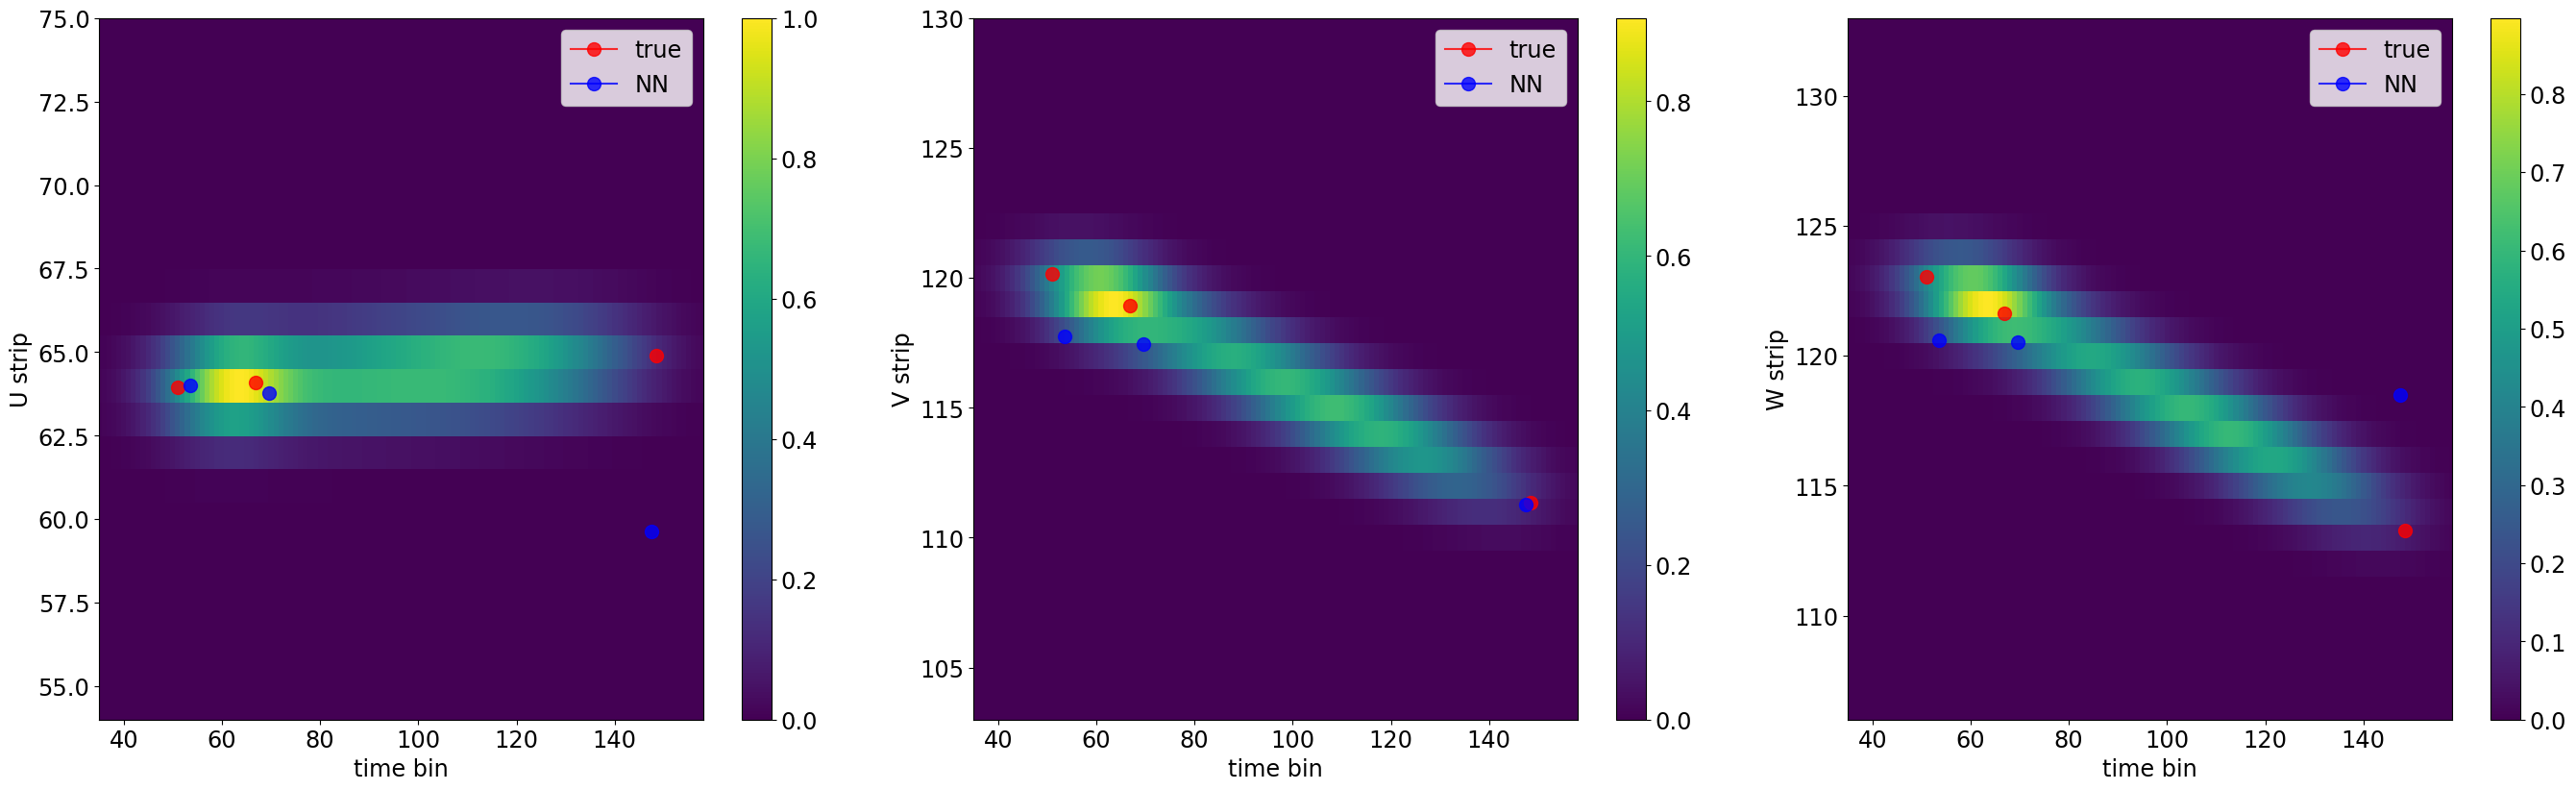

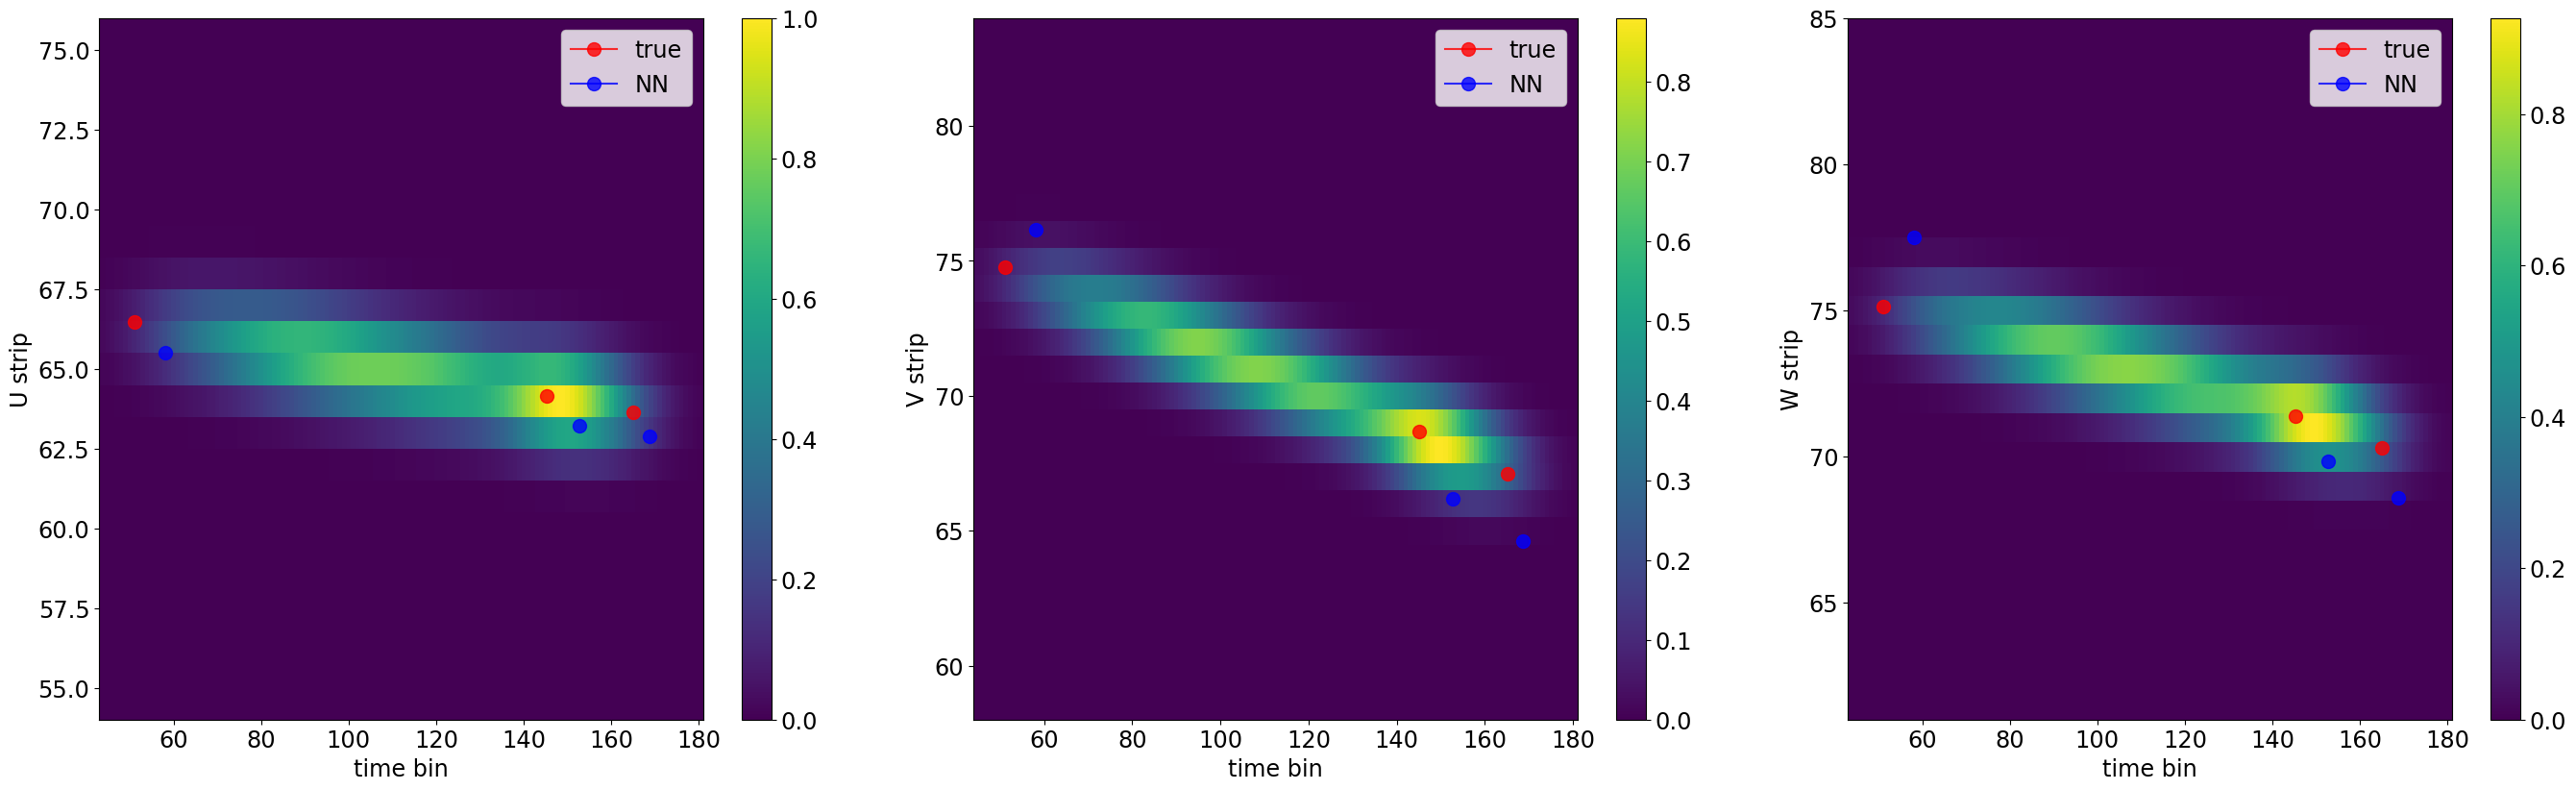

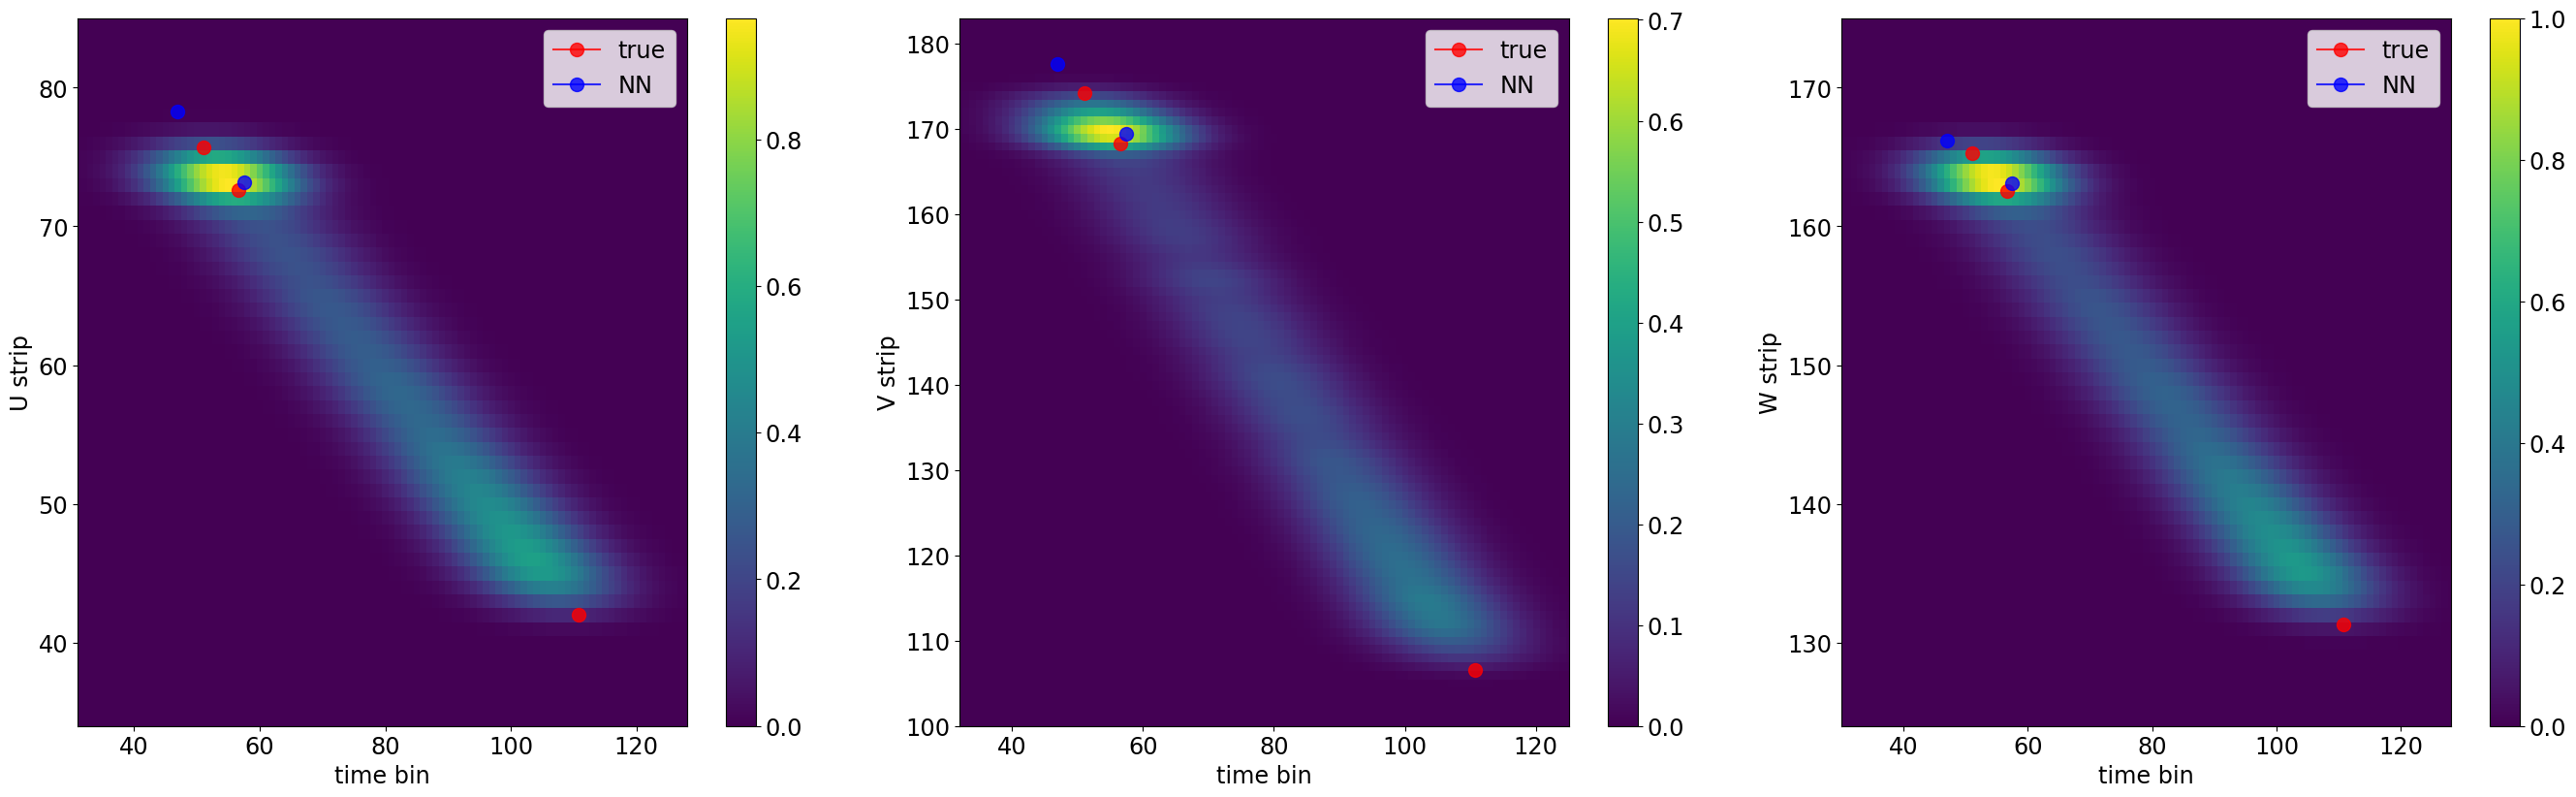

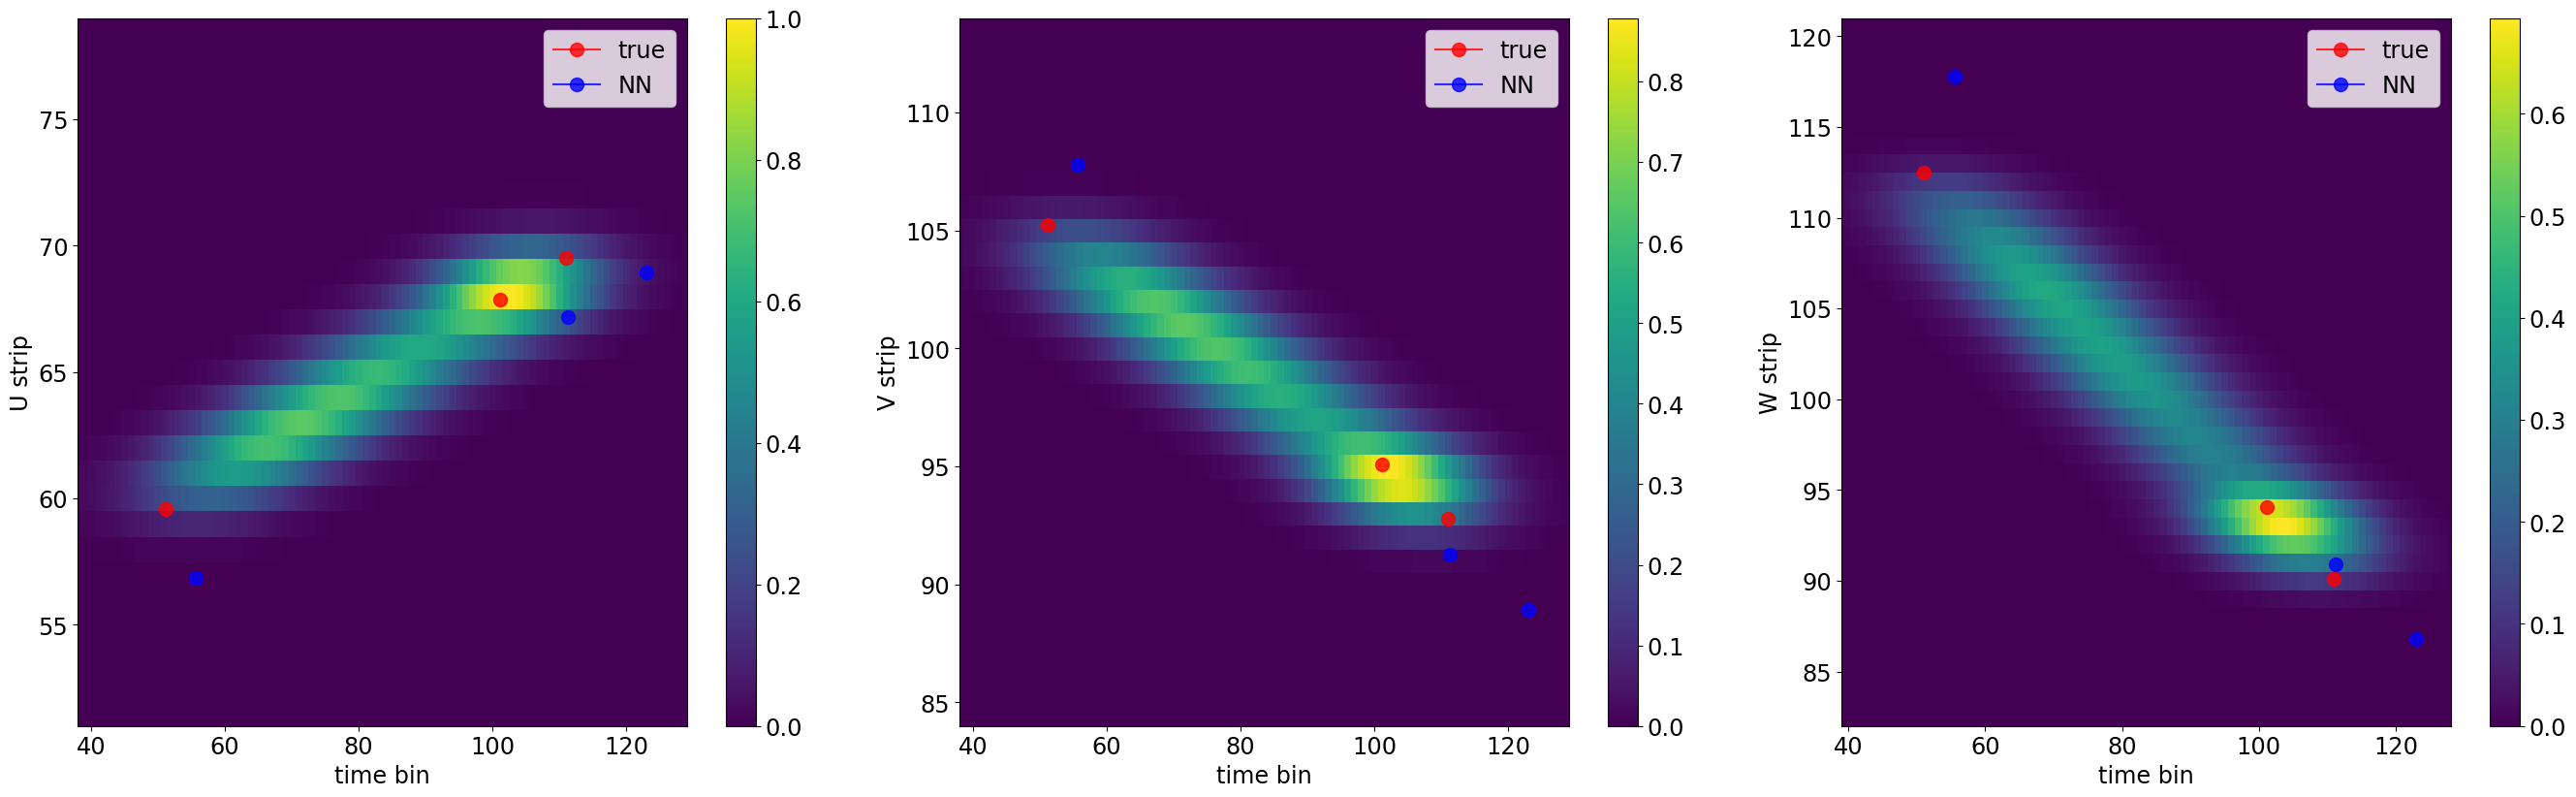

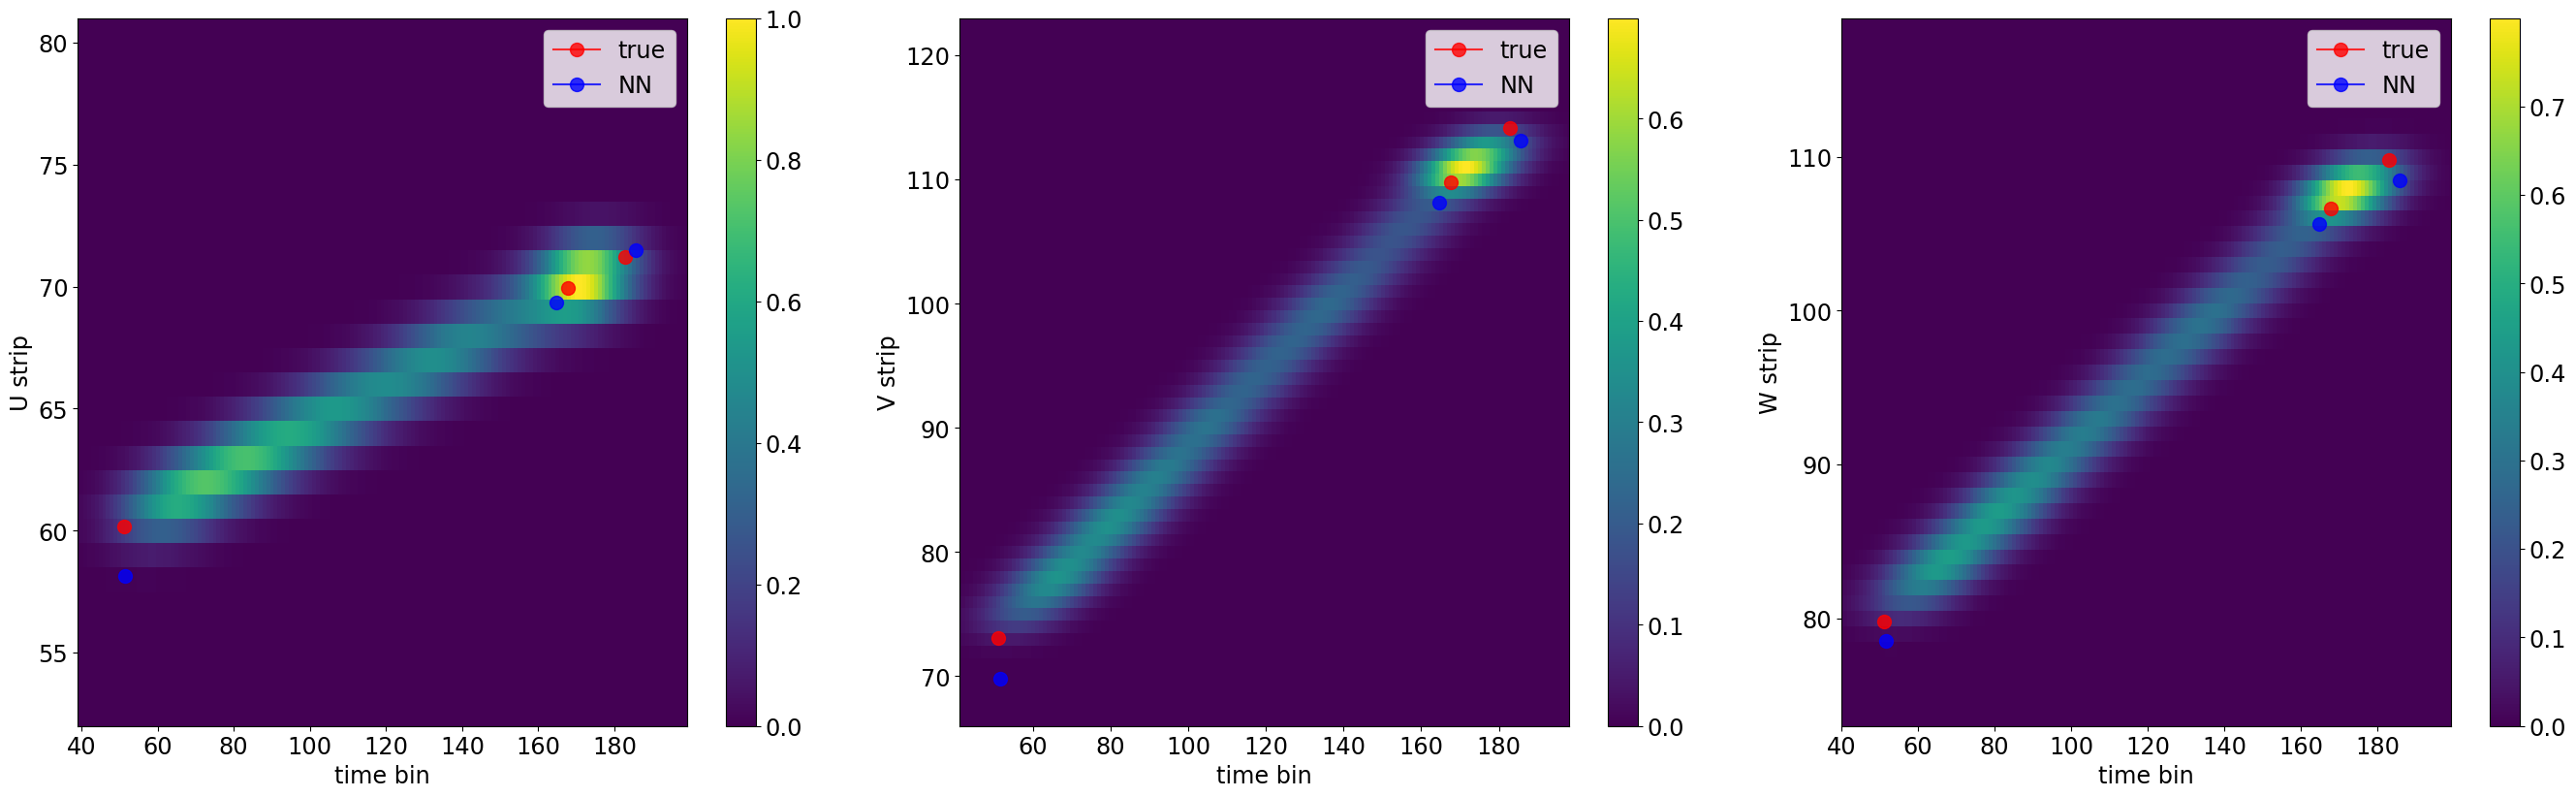

In [8]:
%%time
import utility_functions as utils
importlib.reload(utils)

current_time = datetime.now().strftime("%Y_%b_%d_%H_%M_%S")
print("Inference. Current Time =", current_time)

#model_path = "./training/2023_Apr_28_16_58_32/"
#model_path = "/scratch_hdd/akalinow/ELITPC/PythonAnalysis/training/2023_May_02_23_51_30/"
#model = tf.keras.models.load_model(model_path)

df = utils.df

for aBatch in test_dataset: 
    df = utils.fillPandasDataset(aBatch, df, model)     
    
for aBatch in test_dataset.take(5):
    plf.plotEvent(aBatch, model=model)

df.describe()    

### Resolution plots

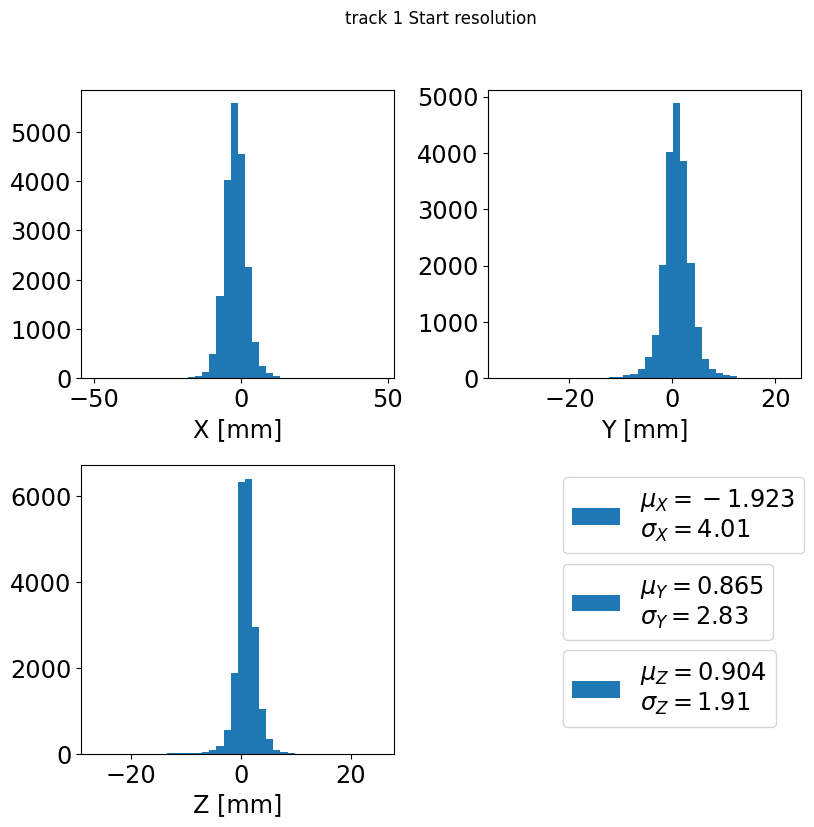

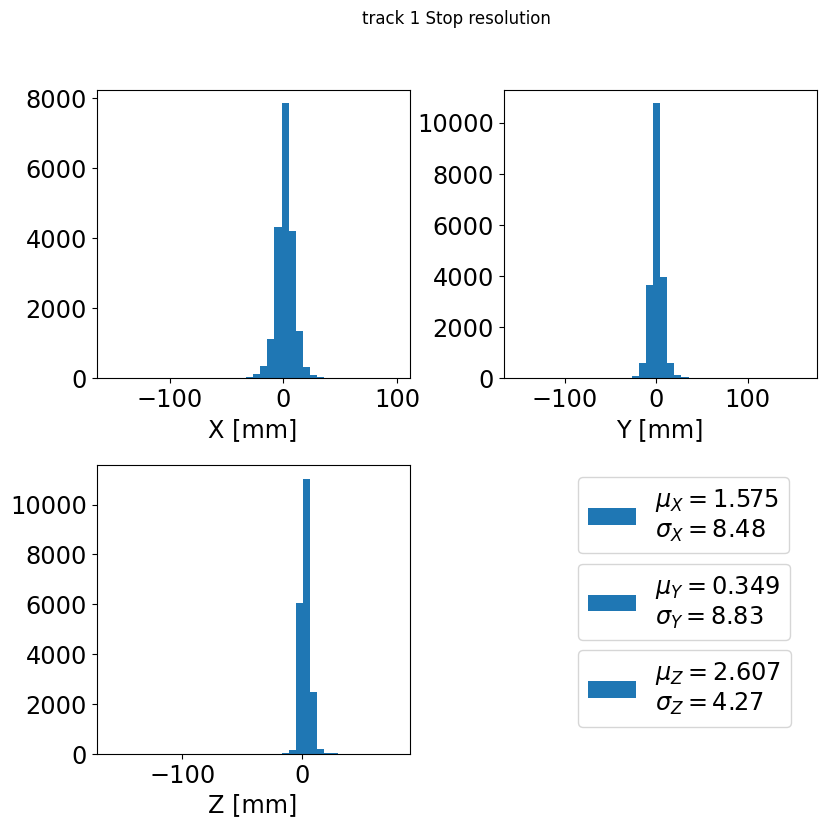

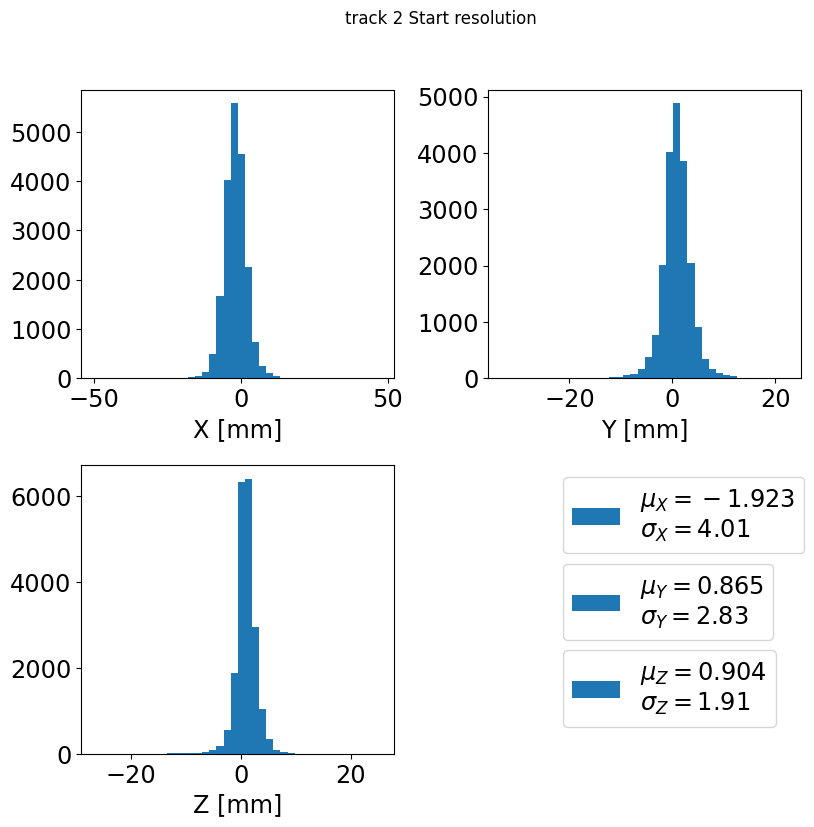

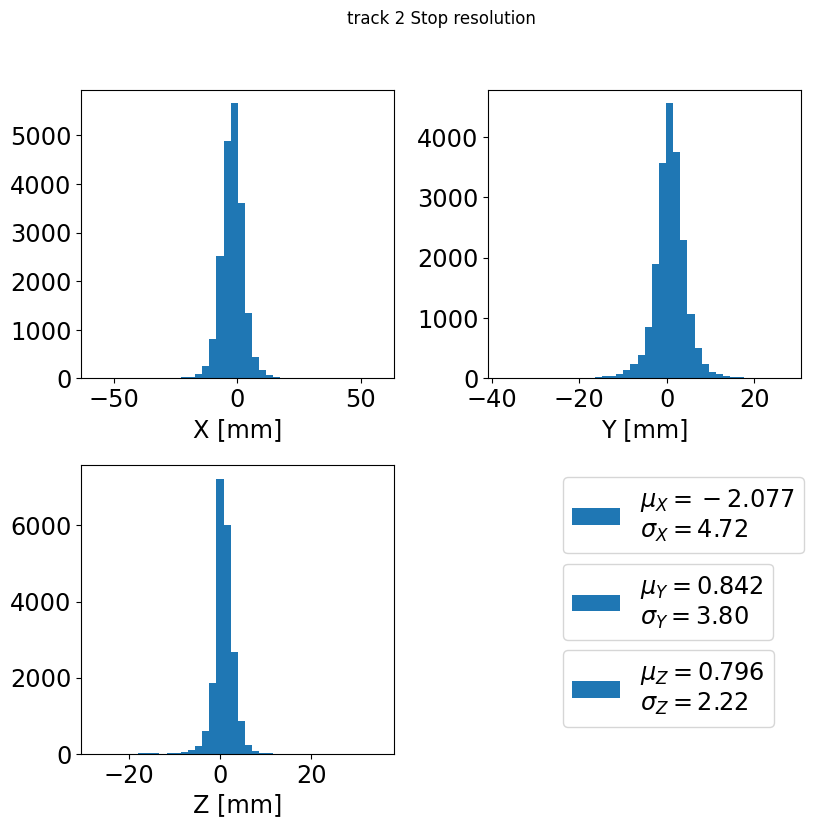

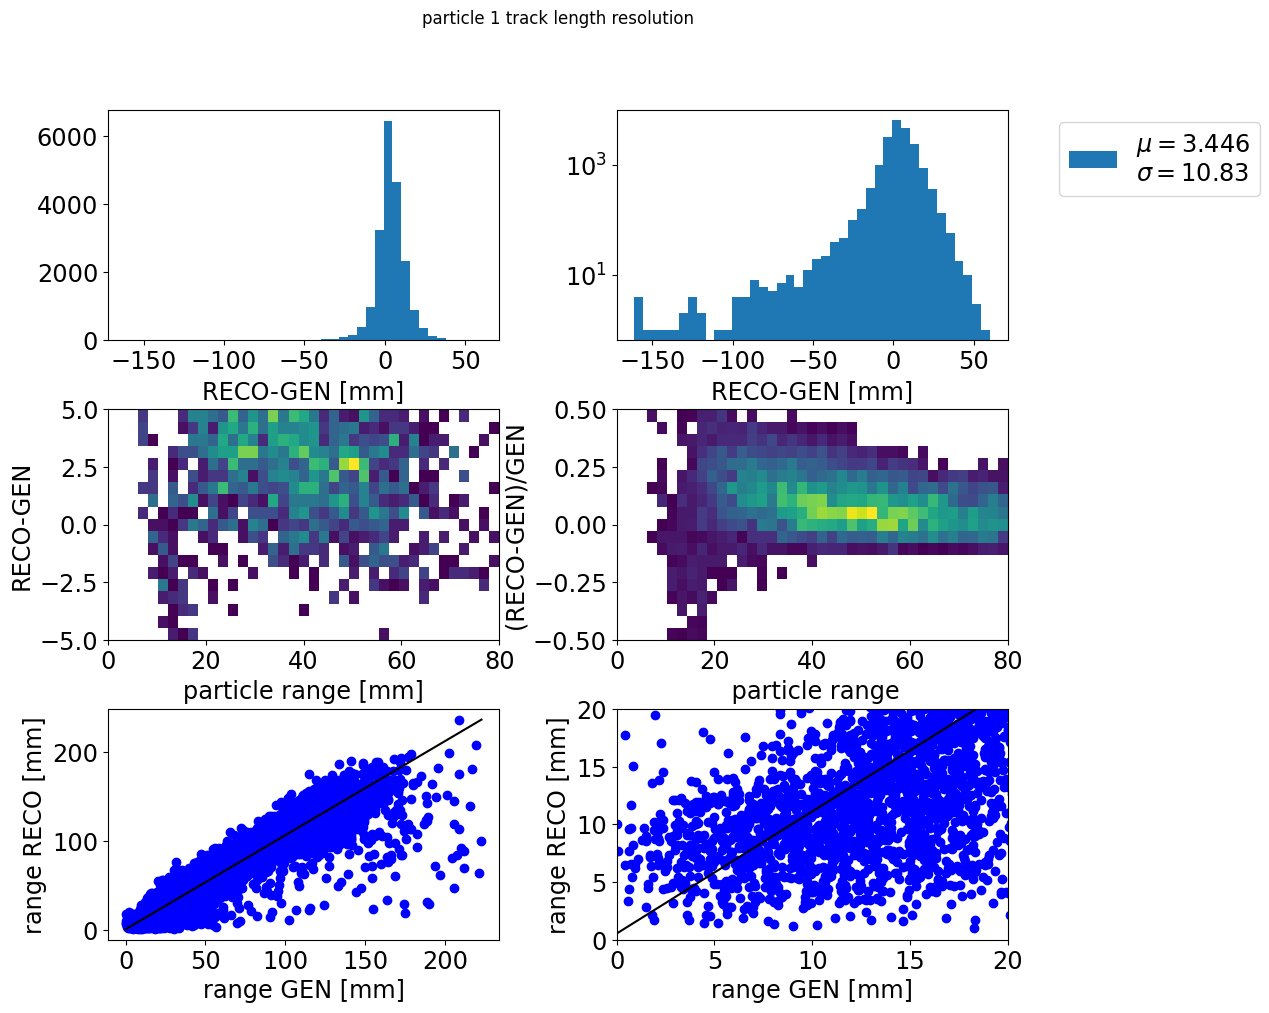

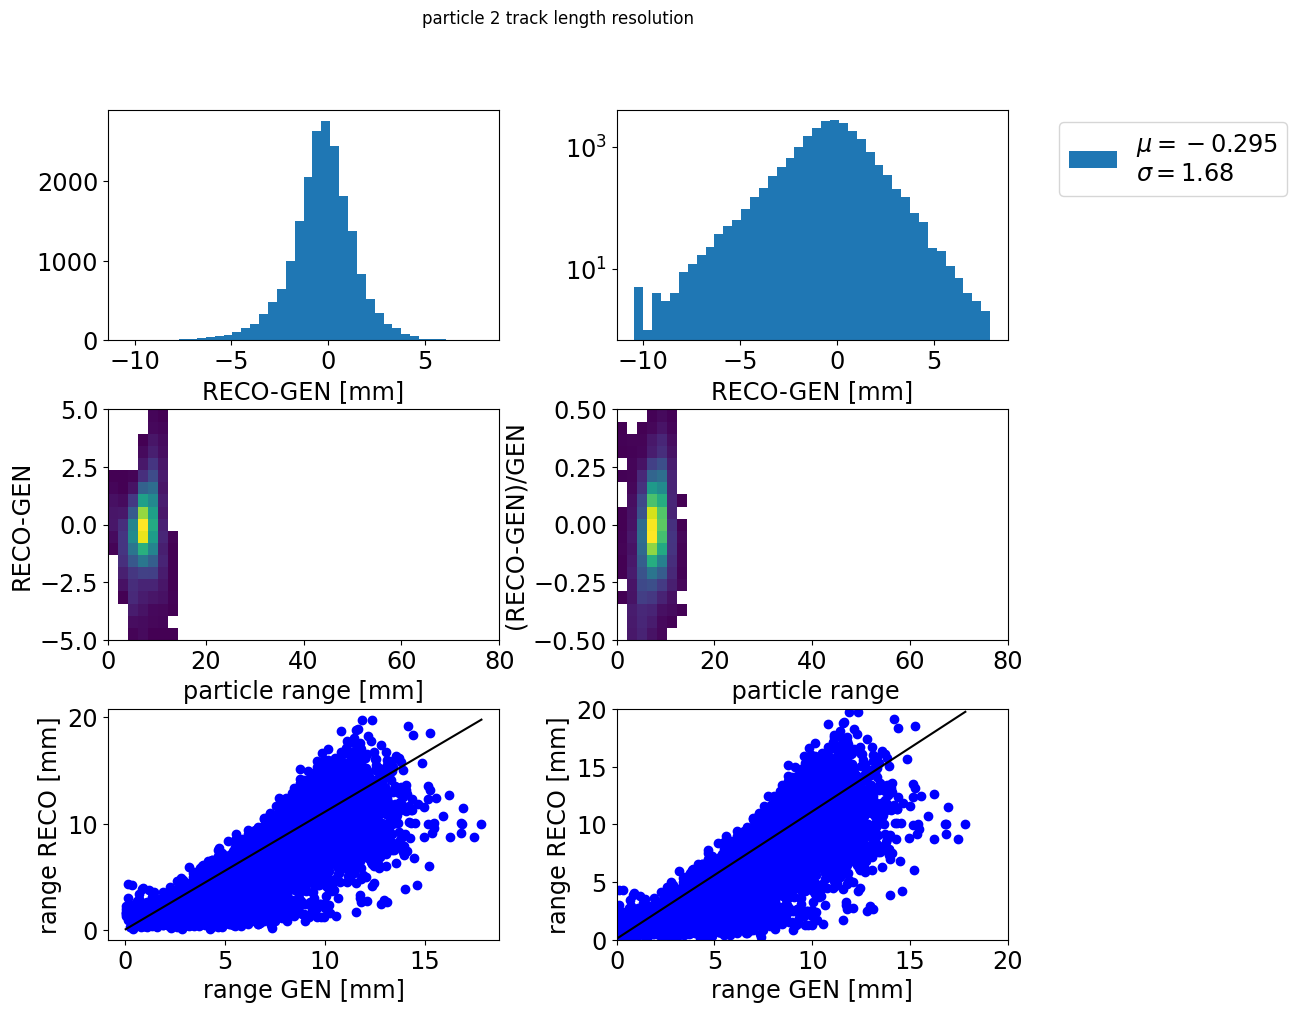

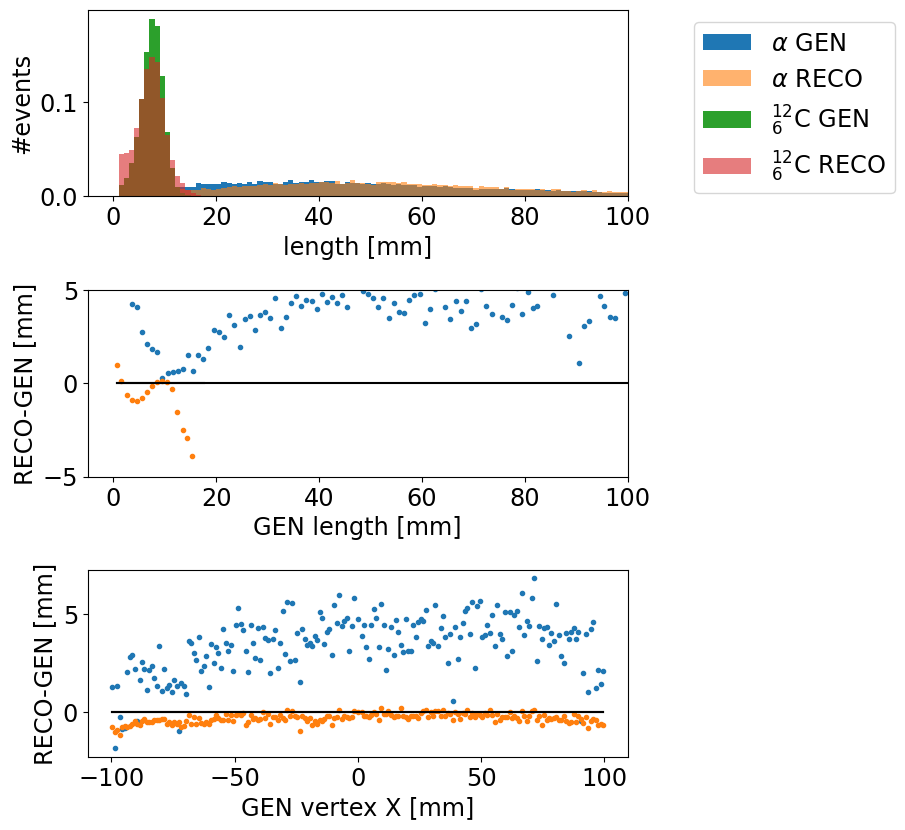

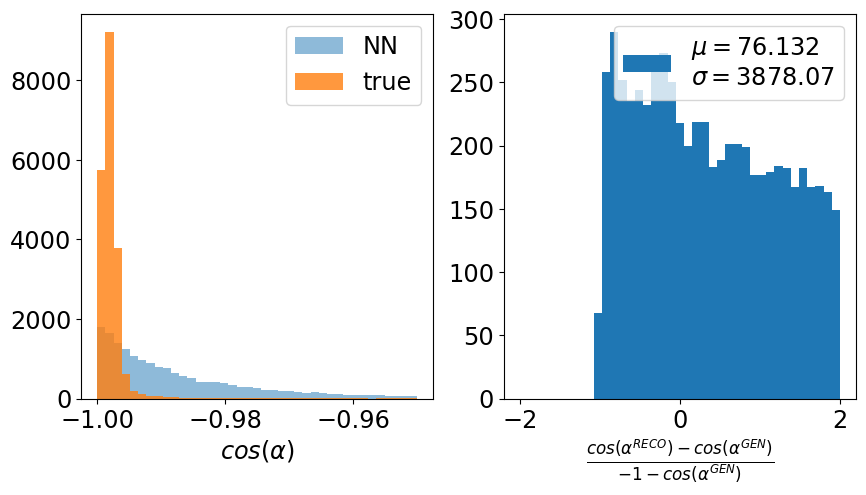

In [9]:
import plotting_functions as plf
importlib.reload(plf)

#plf.controlPlots(df)
plf.plotEndPointRes(df=df, edge="Start", partIdx=1)
plf.plotEndPointRes(df=df, edge="Stop", partIdx=1)

plf.plotEndPointRes(df=df, edge="Start", partIdx=2)
plf.plotEndPointRes(df=df, edge="Stop", partIdx=2)

plf.plotLengthPull(df, partIdx=1)
plf.plotLengthPull(df, partIdx=2)
plf.plotLengthPullEvolution(df)
plf.plotOpeningAngleCos(df)

       GEN_StartPosX  GEN_StartPosY  GEN_StartPosZ  GEN_StopPosX_Part1  \
count    7668.000000    7668.000000    7668.000000         7668.000000   
mean       -1.233685       0.039508     -36.581066           -8.322292   
std        56.078217       9.981635      17.507959           62.071640   
min       -99.994888     -19.926653     -52.936871         -188.313568   
25%       -53.757044      -8.358707     -49.183220          -59.275455   
50%         5.220402      -0.088227     -45.032200           -2.802720   
75%        44.986631       8.301688     -27.881698           40.302917   
max        99.995995      19.955435      55.789871          192.388962   

       GEN_StopPosY_Part1  GEN_StopPosZ_Part1  GEN_StopPosX_Part2  \
count         7668.000000         7668.000000         7668.000000   
mean            -0.012575          -39.567745           -0.784151   
std             29.738657           20.504801           56.510090   
min           -141.898621          -80.722847         -10

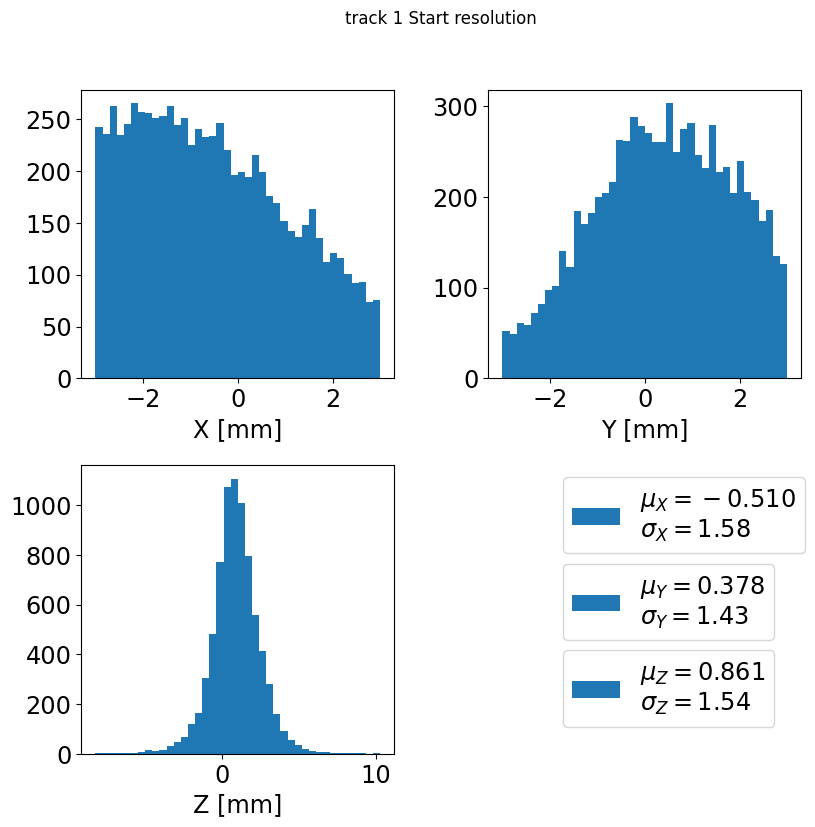

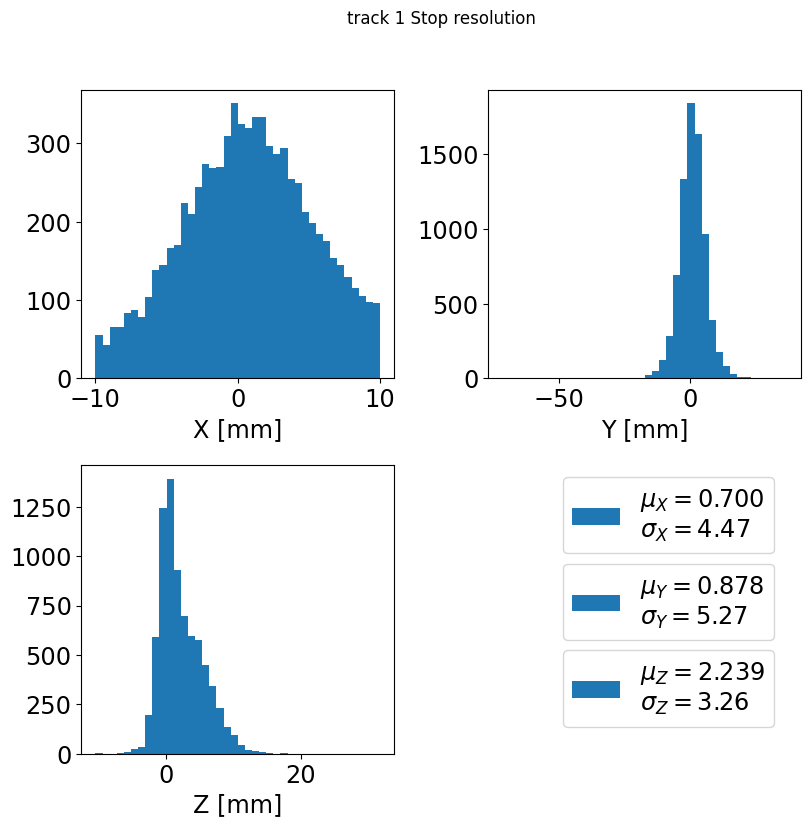

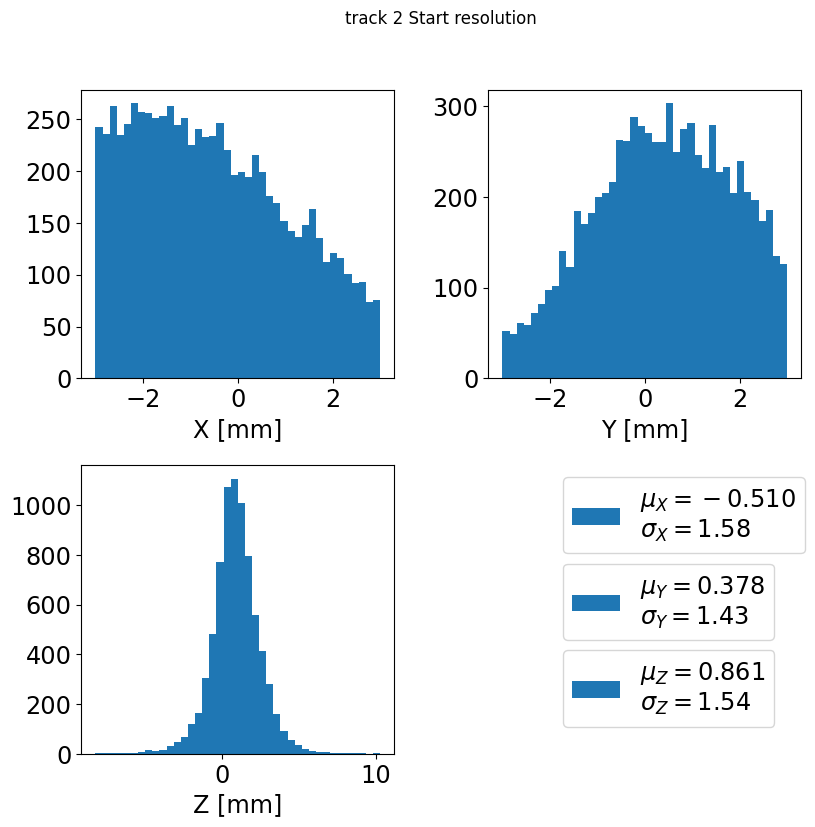

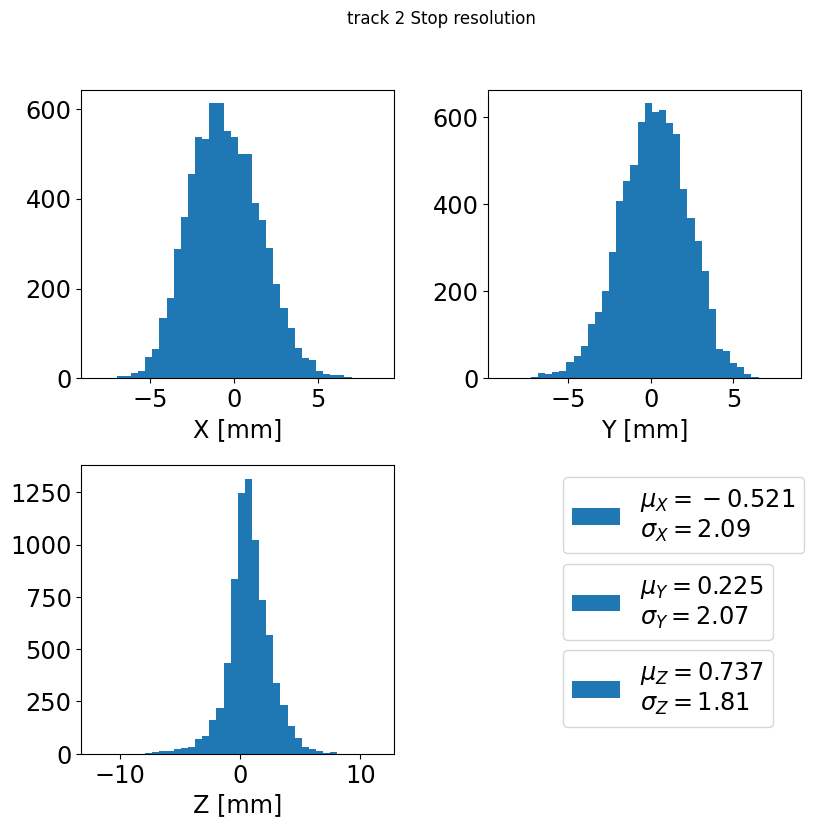

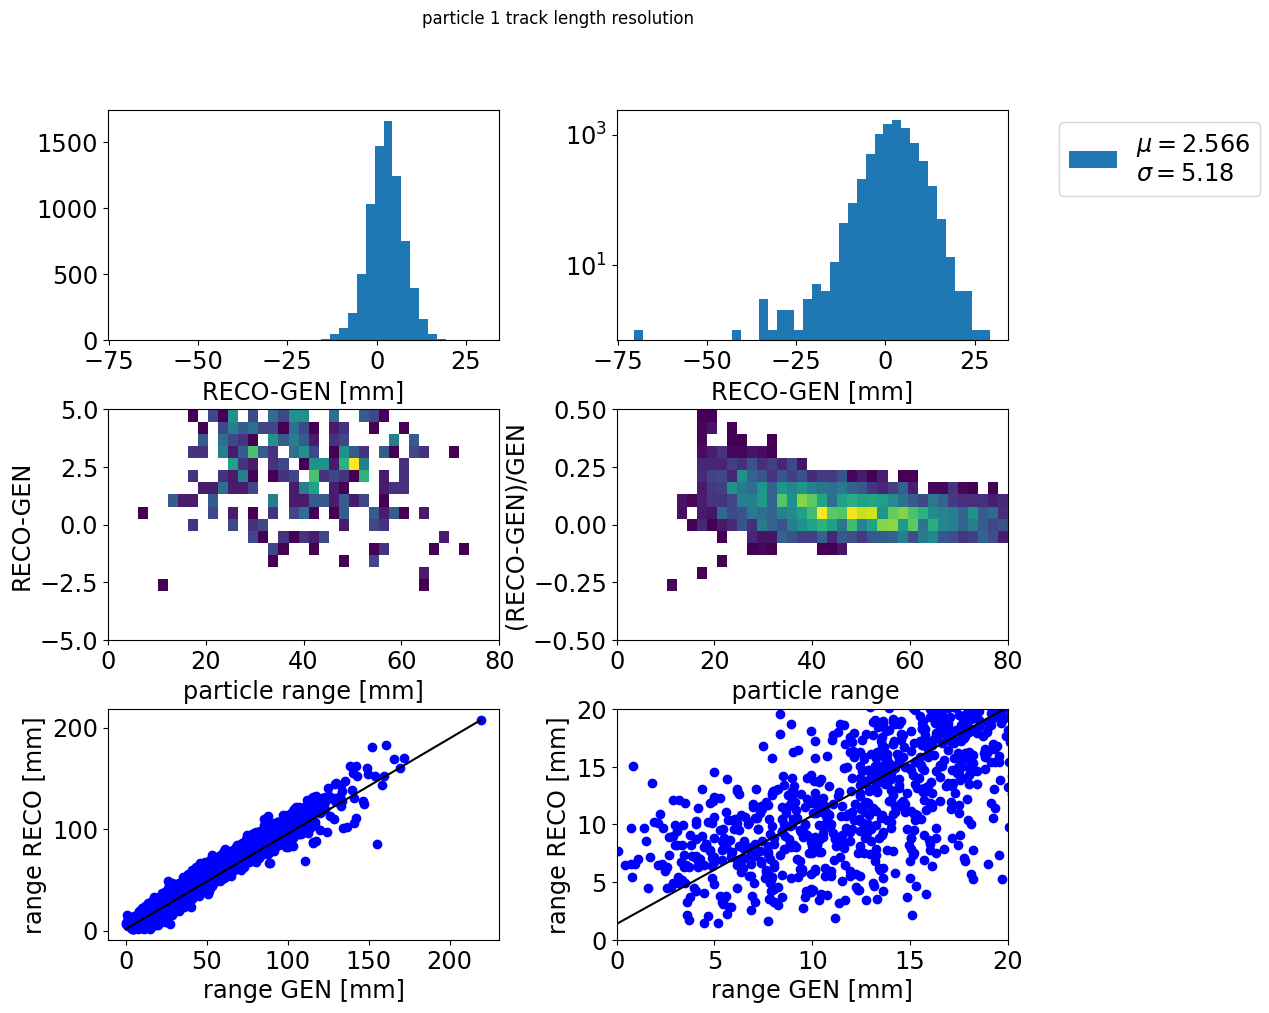

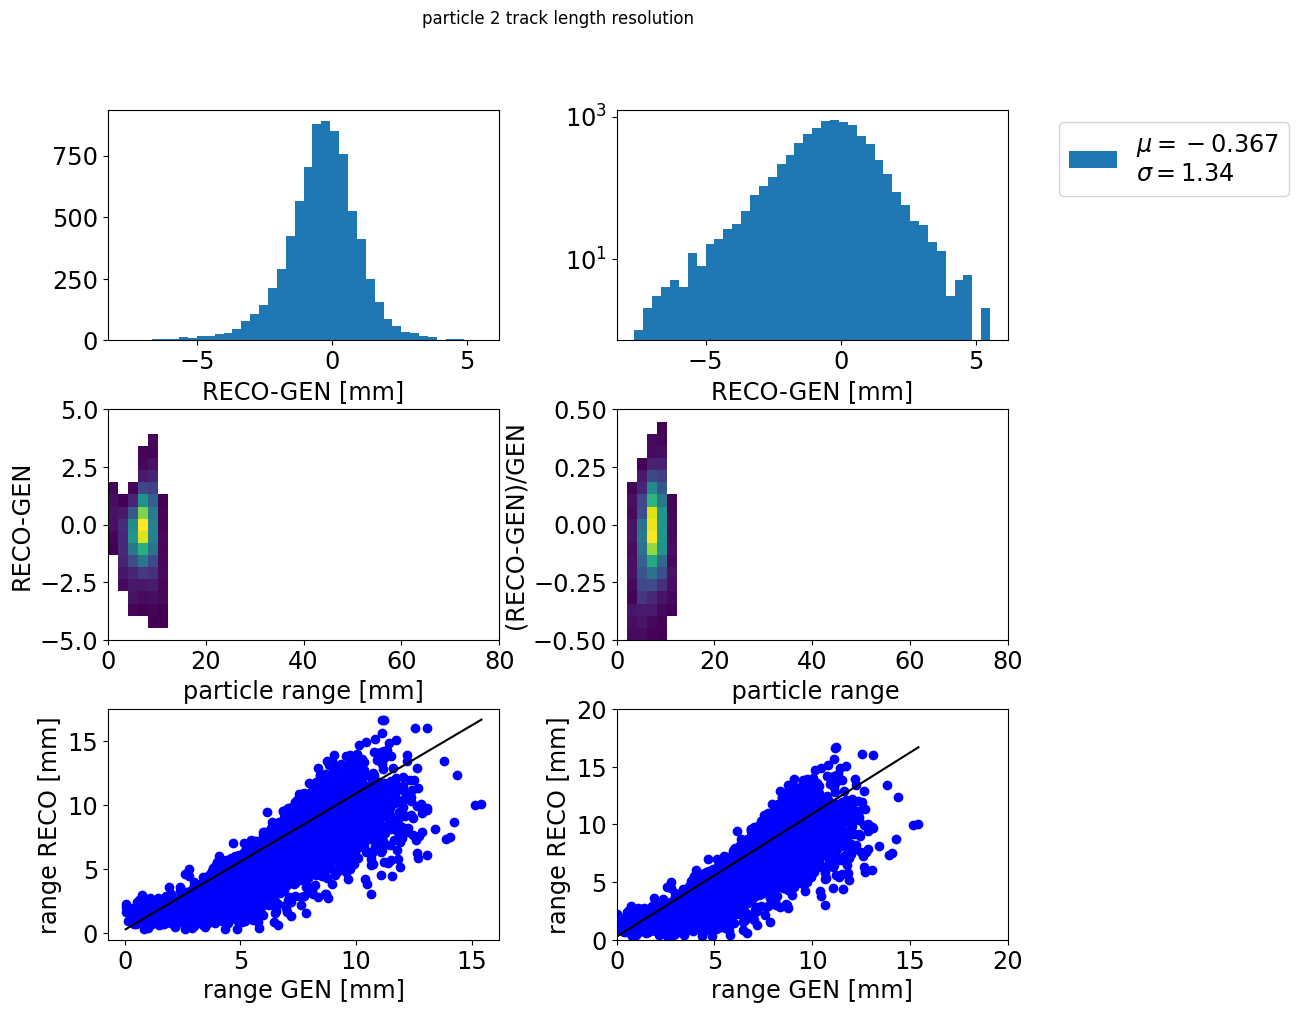

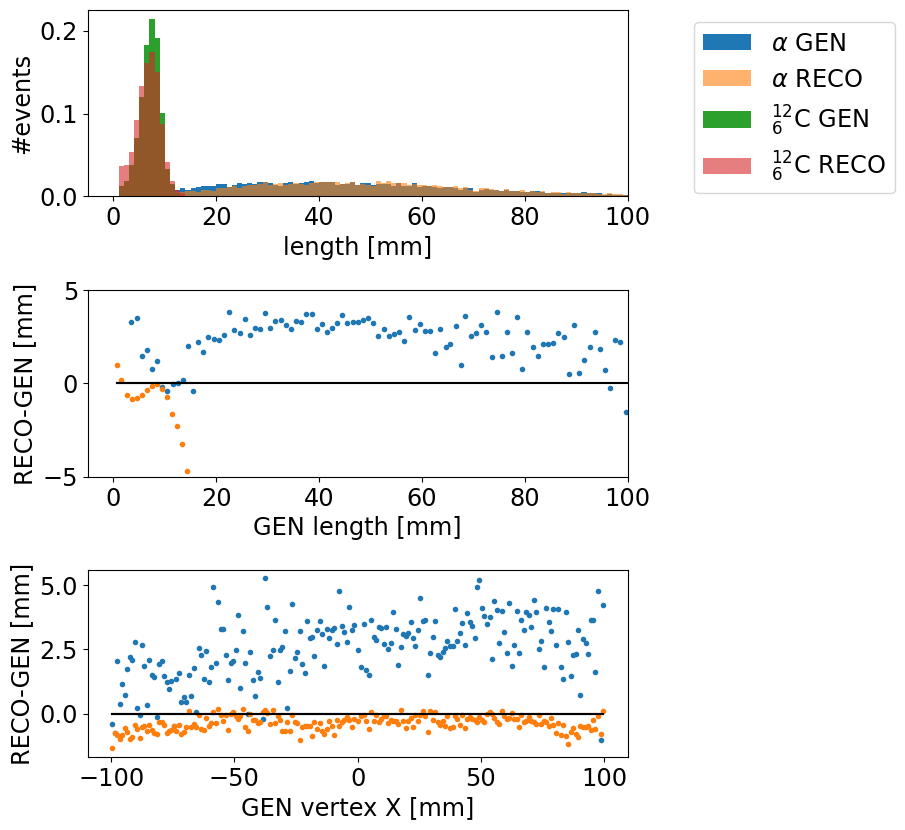

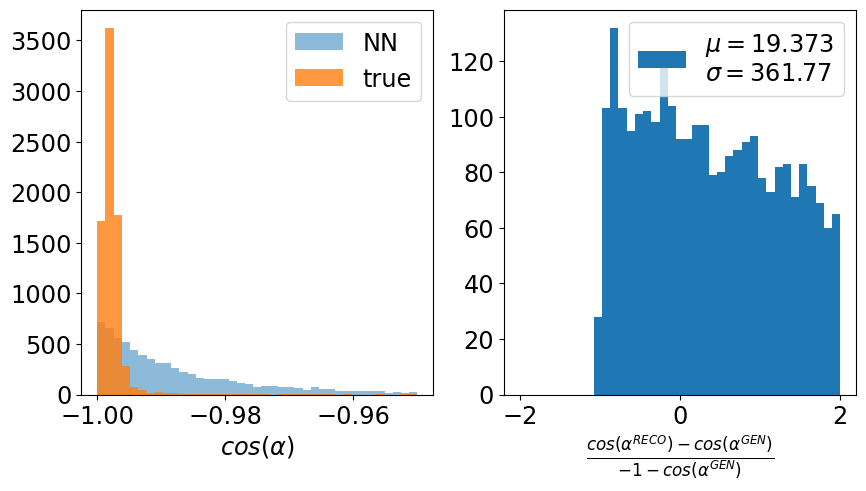

In [7]:
mask = np.abs(df["GEN_StartPosX"] - df["RECO_StartPosX"])<3
df_filtered = df[mask]

mask = np.abs(df_filtered["GEN_StartPosY"] - df_filtered["RECO_StartPosY"])<3
df_filtered = df_filtered[mask]

mask = np.abs(df_filtered["GEN_StopPosX_Part1"] - df_filtered["RECO_StopPosX_Part1"])<10
df_filtered = df_filtered[mask]

print(df_filtered.describe())

plf.plotEndPointRes(df=df_filtered, edge="Start", partIdx=1)
plf.plotEndPointRes(df=df_filtered, edge="Stop", partIdx=1)

plf.plotEndPointRes(df=df_filtered, edge="Start", partIdx=2)
plf.plotEndPointRes(df=df_filtered, edge="Stop", partIdx=2)

plf.plotLengthPull(df_filtered, partIdx=1)
plf.plotLengthPull(df_filtered, partIdx=2)
plf.plotLengthPullEvolution(df_filtered)
plf.plotOpeningAngleCos(df_filtered)